### Importing Needed packages


<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Simple Linear Regression


Estimated time needed: **15** minutes
    

## Objectives

After completing this lab you will be able to:

* Use scikit-learn to implement simple Linear Regression
* Create a model, train it, test it and use the model


In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

<ipython-input-2-76706e26cc54>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Downloading Data
To download the data, we will use !wget to download it from IBM Object Storage.


In [3]:
path= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"

In [4]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())




## Understanding the Data

### `FuelConsumption.csv`:
We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


## Reading the data in


In [5]:
await download(path, "FuelConsumption.csv")
path="FuelConsumption.csv"

In [6]:
df = pd.read_csv("FuelConsumption.csv")

# take a look at the dataset
df.head()



,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


### Data Exploration
Let's first have a descriptive exploration on our data.


In [7]:
# summarize the data
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


Let's select some features to explore more.


In [8]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(9)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244
5,3.5,6,10.0,230
6,3.5,6,10.1,232
7,3.7,6,11.1,255
8,3.7,6,11.6,267


We can plot each of these features:


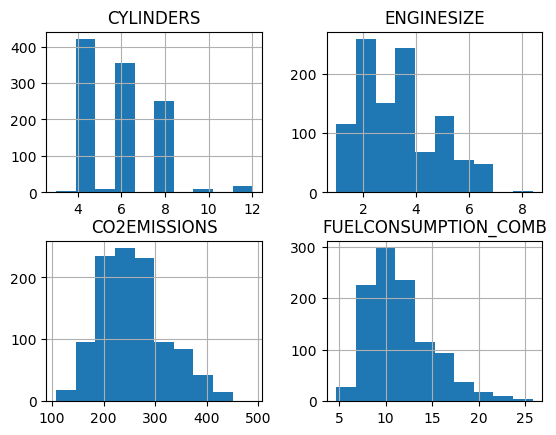

In [9]:
viz = cdf[['CYLINDERS','ENGINESIZE','CO2EMISSIONS','FUELCONSUMPTION_COMB']]
viz.hist()
plt.show()

Now, let's plot each of these features against the Emission, to see how linear their relationship is:


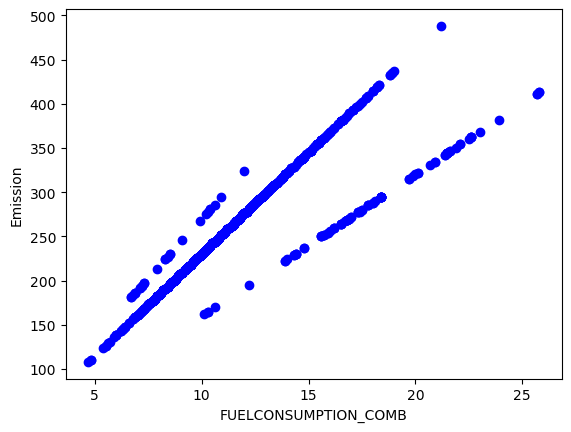

In [10]:
plt.scatter(cdf.FUELCONSUMPTION_COMB, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("FUELCONSUMPTION_COMB")
plt.ylabel("Emission")
plt.show()

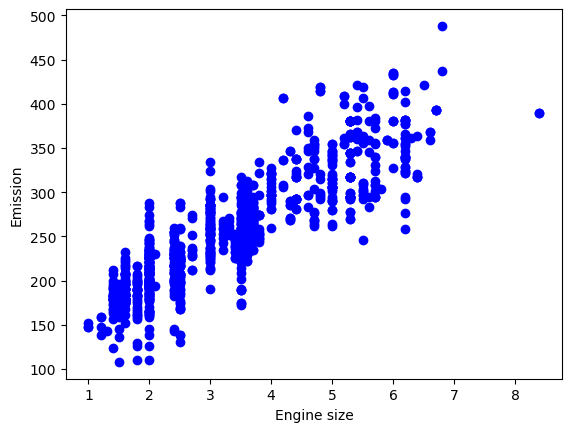

In [11]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

## Practice
Plot __CYLINDER__ vs the Emission, to see how linear is their relationship is:


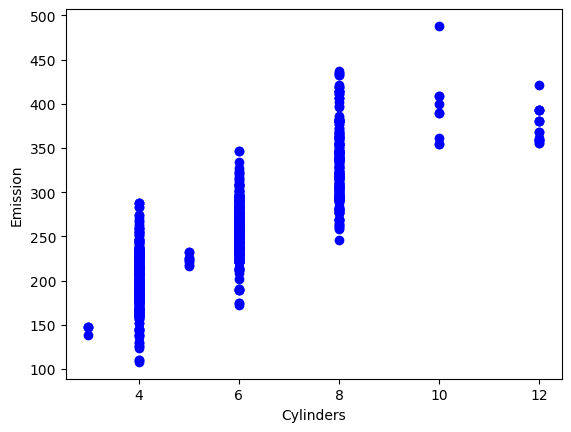

In [12]:
# write your code here
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS, color='blue')
plt.xlabel("Cylinders")
plt.ylabel("Emission")
plt.show()

<details><summary>Click here for the solution</summary>

```python    
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS, color='blue')
plt.xlabel("Cylinders")
plt.ylabel("Emission")
plt.show()

```

</details>


#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets that are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

This means that we know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using __np.random.rand()__ function: 


In [13]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Simple Regression Model
Linear Regression fits a linear model with coefficients B = (B1, ..., Bn) to minimize the 'residual sum of squares' between the actual value y in the dataset, and the predicted value yhat using linear approximation. 


#### Train data distribution


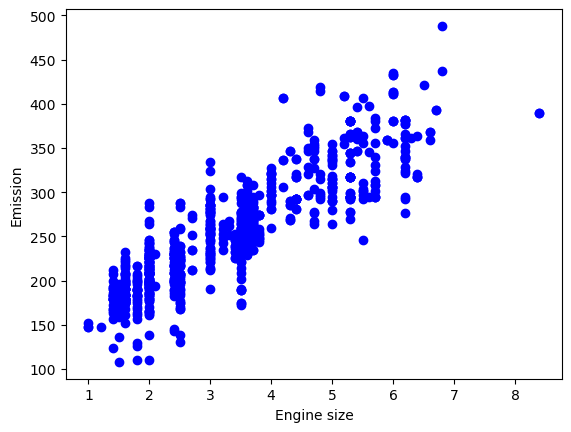

In [14]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Modeling
Using sklearn package to model data.


In [15]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit(train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[38.76957887]]
Intercept:  [126.01923632]


As mentioned before, __Coefficient__ and __Intercept__ in the simple linear regression, are the parameters of the fit line. 
Given that it is a simple linear regression, with only 2 parameters, and knowing that the parameters are the intercept and slope of the line, sklearn can estimate them directly from our data. 
Notice that all of the data must be available to traverse and calculate the parameters.


#### Plot outputs


We can plot the fit line over the data:


Text(0, 0.5, 'Emission')

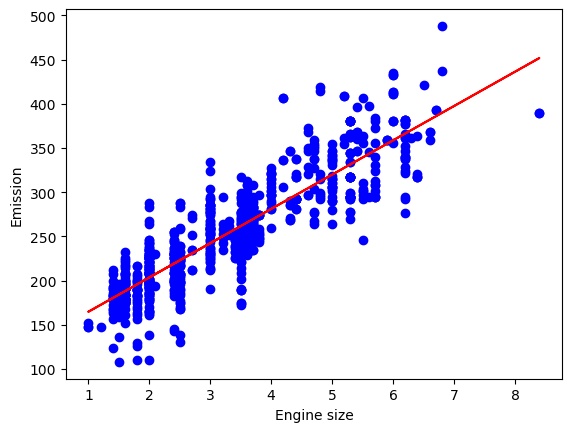

In [16]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")

#### Evaluation
We compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set: 
* Mean Absolute Error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.

* Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean Absolute Error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.

* Root Mean Squared Error (RMSE). 

* R-squared is not an error, but rather a popular metric to measure the performance of your regression model. It represents how close the data points are to the fitted regression line. The higher the R-squared value, the better the model fits your data. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).


In [17]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Mean absolute error: 25.96
Residual sum of squares (MSE): 1136.91
R2-score: 0.74


## Exercise


Lets see what the evaluation metrics are if we trained a regression model using the `FUELCONSUMPTION_COMB` feature.

Start by selecting `FUELCONSUMPTION_COMB` as the train_x data from the `train` dataframe, then select `FUELCONSUMPTION_COMB` as the test_x data from the `test` dataframe


In [18]:
train_x = np.asanyarray(train[['FUELCONSUMPTION_COMB']])    #ADD CODE

test_x = np.asanyarray(test[['FUELCONSUMPTION_COMB']])    #ADD CODE



<details><summary>Click here for the solution</summary>

```python    
train_x = train[["FUELCONSUMPTION_COMB"]]

test_x = test[["FUELCONSUMPTION_COMB"]]

```

</details>


Now train a Linear Regression Model using the `train_x` you created and the `train_y` created previously


In [19]:
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)

#ADD CODE


LinearRegression()

<details><summary>Click here for the solution</summary>

```python    
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)

```

</details>


Find the predictions using the model's `predict` function and the `test_x` data


In [20]:
predictions = regr.predict(test_x)  #ADD CODE

<details><summary>Click here for the solution</summary>

```python    
predictions = regr.predict(test_x)

```

</details>


Finally use the `predictions` and the `test_y` data and find the Mean Absolute Error value using the `np.absolute` and `np.mean` function like done previously


In [21]:
print("Mean Absolute Error: %.2f" % np.mean(np.absolute(predictions - test_y)))


Mean Absolute Error: 21.37


<details><summary>Click here for the solution</summary>

```python    
print("Mean Absolute Error: %.2f" % np.mean(np.absolute(predictions - test_y)))

```

</details>


We can see that the MAE is much worse when we train using `ENGINESIZE` than `FUELCONSUMPTION_COMB`.
